<a href="https://colab.research.google.com/github/PrakhovEgor/data_sets/blob/main/detectron2_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-s2nlitwc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-s2nlitwc
  Resolved https://github.com/facebookresearch/detectron2.git to commit 7d2e68dbe452fc422268d40ac185ea2609affca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 837.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6112369 sha256=495fb7fa782b1203a62e50acd2d35a4

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [4]:
!wget https://zaborshicov.ru/hiden/dataset_seagulls.zip -O dataset.zip
!unzip dataset.zip > /dev/null

--2023-08-17 11:01:21--  https://zaborshicov.ru/hiden/dataset_seagulls.zip
Resolving zaborshicov.ru (zaborshicov.ru)... 46.8.141.165, 2a0b:6cc0::15
Connecting to zaborshicov.ru (zaborshicov.ru)|46.8.141.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38431264 (37M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  36.65M  6.15MB/s    in 6.2s    

2023-08-17 11:01:30 (5.87 MB/s) - ‘dataset.zip’ saved [38431264/38431264]



In [5]:
import os
import numpy as np
from PIL import Image
from detectron2.structures import BoxMode


def get_dicts(typeof="train"):
    # Пути к папкам с изображениями и метками
    images_folder = f"{typeof}/images"
    labels_folder = f"{typeof}/labels"

    # Создание списка файлов для обработки
    image_files = os.listdir(images_folder)
    label_files = os.listdir(labels_folder)

    dataset_dicts = []

    for label_file in label_files:
        image_id = '.'.join(label_file.split('.')[:-1])
        image_path = os.path.join(images_folder, f"{image_id}.jpg")
        label_path = os.path.join(labels_folder, label_file)

        # Чтение меток из файла
        with open(label_path, 'r') as f:
            lines = f.readlines()

        annotations = []
        height, width = cv2.imread(image_path).shape[:2]
        for line in lines:
            parts = line.strip().split(' ')
            class_id, X_CENTER_NORM, Y_CENTER_NORM, WIDTH_NORM, HEIGHT_NORM = map(float, parts)


            x_center = X_CENTER_NORM * width
            y_center = Y_CENTER_NORM * height
            bbox_width = WIDTH_NORM * width
            bbox_height = HEIGHT_NORM * height

            x_min = x_center - bbox_width / 2
            y_min = y_center - bbox_height / 2
            x_max = x_center + bbox_width / 2
            y_max = y_center + bbox_height / 2



            annotation = {
                "bbox": [x_min, y_min, x_max, y_max],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(class_id)
            }
            annotations.append(annotation)


        coco_data = {
            "file_name": image_path,
            "image_id": image_id,
            "height": height,
            "width": width,
            "annotations": annotations
        }
        dataset_dicts.append(coco_data)
    return dataset_dicts


DatasetCatalog.clear()
for d in ["train", "valid"]:
    DatasetCatalog.register("Seagull_" + d, lambda d=d: get_dicts(d))
    MetadataCatalog.get("Seagull_" + d).set(thing_classes=["seagull"])
metadata = MetadataCatalog.get("Seagull_train")

{'file_name': 'train/images/20200814_134704_01_JPG.rf.110802f614204de7c97cf1ac8382821b.jpg', 'image_id': '20200814_134704_01_JPG.rf.110802f614204de7c97cf1ac8382821b', 'height': 640, 'width': 640, 'annotations': [{'bbox': [291.0, 485.5, 313.0, 520.5], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [355.0, 425.25, 377.0, 454.75], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [224.5, 464.25, 245.5, 489.75], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [351.0, 504.25, 378.0, 549.75], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [320.0, 396.0, 342.0, 423.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [245.25, 414.25, 259.75, 429.75], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [229.75, 406.5, 248.25, 427.5], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [223.75, 433.5, 242.25, 457.5], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [194.0, 500.0

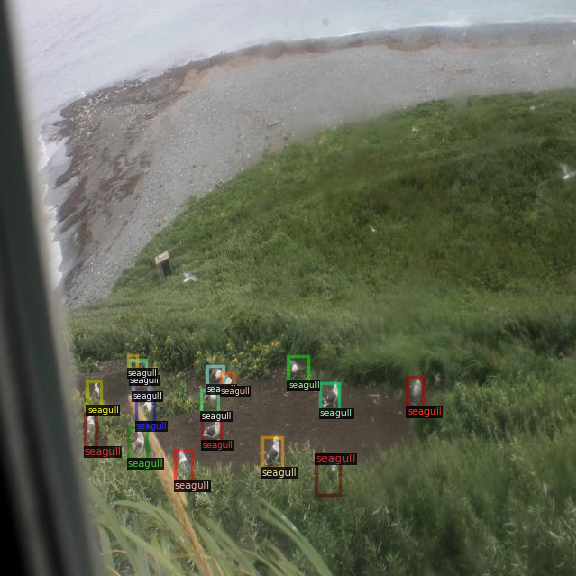

{'file_name': 'train/images/20200914_122506_01_JPG.rf.2a16ac0fdc5e35d3b41fa919b723614e.jpg', 'image_id': '20200914_122506_01_JPG.rf.2a16ac0fdc5e35d3b41fa919b723614e', 'height': 640, 'width': 640, 'annotations': [{'bbox': [225.0, 395.75, 240.0, 415.25], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [94.25, 470.75, 113.75, 494.25], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [327.25, 419.75, 347.75, 440.25], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [361.0, 466.0, 390.0, 494.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


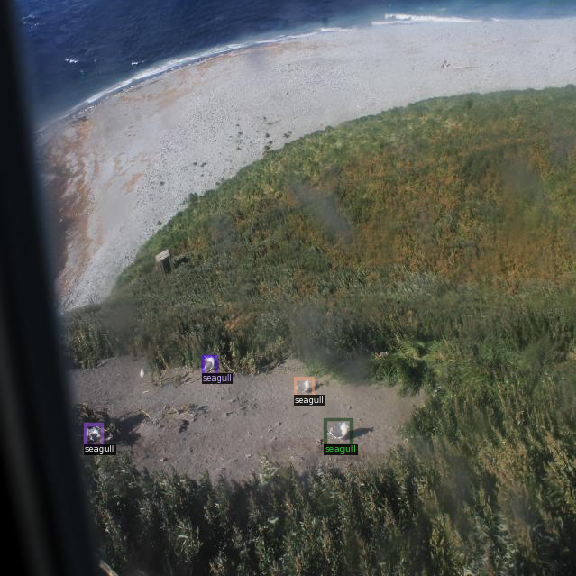

{'file_name': 'train/images/20200523_140733_01_JPG.rf.40574b13b11a4d350c2b37c4ef11fbb0.jpg', 'image_id': '20200523_140733_01_JPG.rf.40574b13b11a4d350c2b37c4ef11fbb0', 'height': 640, 'width': 640, 'annotations': [{'bbox': [124.0, 407.5, 146.0, 433.5], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [215.0, 433.5, 238.0, 459.5], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [187.75, 619.0, 227.25, 640.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [200.5, 524.5, 226.5, 557.5], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [242.75, 408.0, 257.25, 427.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [401.25, 433.75, 422.75, 472.25], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [423.5, 443.25, 450.5, 476.75], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [427.0, 506.75, 458.0, 538.25], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [521.75, 559.25

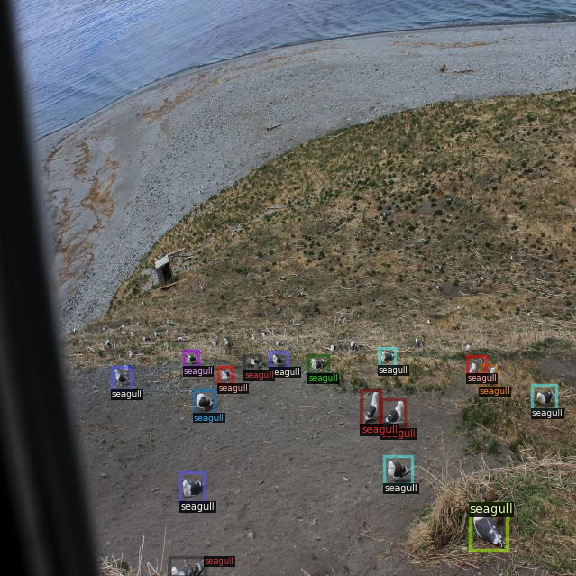

In [6]:
dataset_dicts = get_dicts("train")
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.9)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Seagull_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/17 11:02:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_721ade.pkl: 136MB [00:00, 230MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[08/17 11:02:17 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/17 11:02:46 d2.utils.events]:  eta: 0:01:43  iter: 19  total_loss: 0.9616  loss_cls: 0.6529  loss_box_reg: 0.1708  loss_rpn_cls: 0.09928  loss_rpn_loc: 0.03088    time: 1.2925  last_time: 1.3191  data_time: 0.0176  last_data_time: 0.0045   lr: 4.7703e-05  max_mem: 4253M
[08/17 11:03:16 d2.utils.events]:  eta: 0:01:18  iter: 39  total_loss: 0.4838  loss_cls: 0.2535  loss_box_reg: 0.1038  loss_rpn_cls: 0.08479  loss_rpn_loc: 0.02352    time: 1.3098  last_time: 1.3395  data_time: 0.0103  last_data_time: 0.0171   lr: 9.7653e-05  max_mem: 4254M


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import mean_squared_error as mse

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


y = []
preds = []
dataset_dicts = get_dicts("valid")

for d in dataset_dicts:
    f = open(d["file_name"].replace("images", "labels").replace(".jpg", ".txt"))

    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    y.append(len(list(f)))
    preds.append(len(outputs["instances"].get_fields()["pred_boxes"]))

print(f'RMSE = {mse(y, preds, squared=False)**0.5}')

[08/15 10:27:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
RMSE = 0.7088856802260898


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

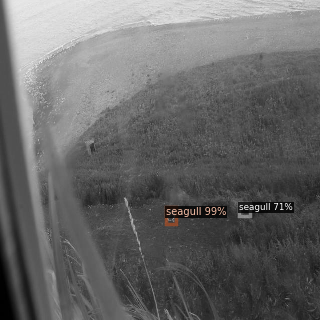

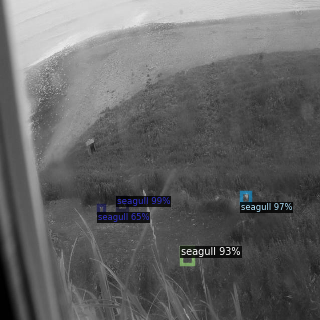

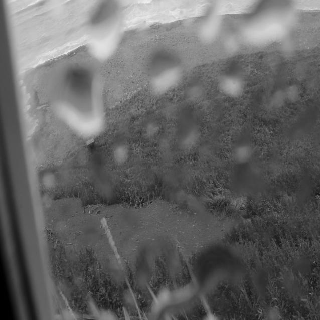

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dicts("valid")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

[08/14 08:12:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


[08/14 08:57:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
RMSE = 1.5421911554804912


In [ ]:
import zipfile
with zipfile.ZipFile("/content/test.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/test")

In [ ]:
import pandas as pd
from glob import glob
paths = []
preds = []
for pth in glob('/content/test/images/*'):
    im = cv2.imread(pth)
    outputs = predictor(im)
    paths.append(pth)
    preds.append(len(outputs['instances'].get_fields()["pred_boxes"]))

df = pd.DataFrame(list(zip(paths, preds)), columns=['filename', 'num'])
print(df)
df.to_csv('/content/count.csv', index=False)

In [ ]:
df